In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "100X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 5


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_100X-BREAKHIS-Dataset-60-10-30-VGGINet/5'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/100X/5'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1128 files belonging to 2 classes.


Found 187 files belonging to 2 classes.


Found 566 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3028 - accuracy: 0.4766

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 4.6050 - accuracy: 0.5898

3/9 [=========>....................] - ETA: 8s - loss: 3.8328 - accuracy: 0.6615

4/9 [============>.................] - ETA: 6s - loss: 3.5884 - accuracy: 0.6934

5/9 [===============>..............] - ETA: 7s - loss: 3.8934 - accuracy: 0.6938

6/9 [===================>..........] - ETA: 5s - loss: 3.6480 - accuracy: 0.7135

7/9 [======================>.......] - ETA: 3s - loss: 3.3843 - accuracy: 0.7344

8/9 [=========================>....] - ETA: 1s - loss: 3.3000 - accuracy: 0.7471

9/9 [==============================] - ETA: 0s - loss: 3.2481 - accuracy: 0.7580

9/9 [==============================] - 29s 3s/step - loss: 3.2481 - accuracy: 0.7580 - val_loss: 4.5065 - val_accuracy: 0.8717


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 2.6677 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 11s - loss: 2.4377 - accuracy: 0.8555

3/9 [=========>....................] - ETA: 8s - loss: 2.0133 - accuracy: 0.8880 

4/9 [============>.................] - ETA: 9s - loss: 1.8747 - accuracy: 0.8750

5/9 [===============>..............] - ETA: 6s - loss: 1.8529 - accuracy: 0.8781

6/9 [===================>..........] - ETA: 4s - loss: 1.7572 - accuracy: 0.8815

7/9 [======================>.......] - ETA: 2s - loss: 1.7904 - accuracy: 0.8772

8/9 [=========================>....] - ETA: 1s - loss: 1.7029 - accuracy: 0.8838

9/9 [==============================] - ETA: 0s - loss: 1.7258 - accuracy: 0.8821

9/9 [==============================] - 15s 2s/step - loss: 1.7258 - accuracy: 0.8821 - val_loss: 5.4733 - val_accuracy: 0.8449


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.9884 - accuracy: 0.8516

2/9 [=====>........................] - ETA: 14s - loss: 2.2178 - accuracy: 0.8203

3/9 [=========>....................] - ETA: 10s - loss: 2.1232 - accuracy: 0.8333

4/9 [============>.................] - ETA: 9s - loss: 1.9221 - accuracy: 0.8516 

5/9 [===============>..............] - ETA: 7s - loss: 1.7832 - accuracy: 0.8594

6/9 [===================>..........] - ETA: 5s - loss: 1.6433 - accuracy: 0.8672

7/9 [======================>.......] - ETA: 3s - loss: 1.5796 - accuracy: 0.8717

8/9 [=========================>....] - ETA: 1s - loss: 1.5524 - accuracy: 0.8789

9/9 [==============================] - ETA: 0s - loss: 1.4809 - accuracy: 0.8821

9/9 [==============================] - 17s 2s/step - loss: 1.4809 - accuracy: 0.8821 - val_loss: 2.6416 - val_accuracy: 0.8449


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1367 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 3s - loss: 1.0506 - accuracy: 0.8789

3/9 [=========>....................] - ETA: 7s - loss: 1.3747 - accuracy: 0.8724

4/9 [============>.................] - ETA: 6s - loss: 1.7967 - accuracy: 0.8379

5/9 [===============>..............] - ETA: 6s - loss: 1.6672 - accuracy: 0.8594

6/9 [===================>..........] - ETA: 4s - loss: 1.7115 - accuracy: 0.8620

7/9 [======================>.......] - ETA: 2s - loss: 1.8847 - accuracy: 0.8571

8/9 [=========================>....] - ETA: 1s - loss: 1.7860 - accuracy: 0.8623

9/9 [==============================] - ETA: 0s - loss: 1.7168 - accuracy: 0.8661

9/9 [==============================] - 15s 2s/step - loss: 1.7168 - accuracy: 0.8661 - val_loss: 1.5704 - val_accuracy: 0.9251


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1690 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 1.4831 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 10s - loss: 1.4142 - accuracy: 0.9036

4/9 [============>.................] - ETA: 9s - loss: 1.7278 - accuracy: 0.8633 

5/9 [===============>..............] - ETA: 7s - loss: 1.5752 - accuracy: 0.8766

6/9 [===================>..........] - ETA: 5s - loss: 1.4649 - accuracy: 0.8854

7/9 [======================>.......] - ETA: 3s - loss: 1.3575 - accuracy: 0.8929

8/9 [=========================>....] - ETA: 1s - loss: 1.4052 - accuracy: 0.8887

9/9 [==============================] - ETA: 0s - loss: 1.4173 - accuracy: 0.8892

9/9 [==============================] - 16s 2s/step - loss: 1.4173 - accuracy: 0.8892 - val_loss: 1.7552 - val_accuracy: 0.9198


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7406 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 1.2039 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 9s - loss: 1.3029 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 1.1296 - accuracy: 0.9160

5/9 [===============>..............] - ETA: 7s - loss: 1.1486 - accuracy: 0.9000

6/9 [===================>..........] - ETA: 5s - loss: 1.2046 - accuracy: 0.8945

7/9 [======================>.......] - ETA: 3s - loss: 1.1473 - accuracy: 0.8996

8/9 [=========================>....] - ETA: 1s - loss: 1.1343 - accuracy: 0.9014

9/9 [==============================] - ETA: 0s - loss: 1.1641 - accuracy: 0.8989

9/9 [==============================] - 16s 2s/step - loss: 1.1641 - accuracy: 0.8989 - val_loss: 1.7584 - val_accuracy: 0.8930


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1172 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 10s - loss: 1.2514 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 8s - loss: 1.0327 - accuracy: 0.8958 

4/9 [============>.................] - ETA: 8s - loss: 0.9545 - accuracy: 0.9004

5/9 [===============>..............] - ETA: 6s - loss: 0.8819 - accuracy: 0.9078

6/9 [===================>..........] - ETA: 4s - loss: 0.9748 - accuracy: 0.9049

7/9 [======================>.......] - ETA: 2s - loss: 0.9041 - accuracy: 0.9085

8/9 [=========================>....] - ETA: 1s - loss: 0.9072 - accuracy: 0.9082

9/9 [==============================] - ETA: 0s - loss: 0.9546 - accuracy: 0.9078

9/9 [==============================] - 15s 2s/step - loss: 0.9546 - accuracy: 0.9078 - val_loss: 0.8176 - val_accuracy: 0.9519


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8744 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.7966 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.9433 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 9s - loss: 0.9357 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.8526 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 4s - loss: 0.8765 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 0.8547 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.8520 - accuracy: 0.9199

9/9 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.9211

9/9 [==============================] - 16s 2s/step - loss: 0.8228 - accuracy: 0.9211 - val_loss: 0.9246 - val_accuracy: 0.9358


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2127 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 1.0656 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 0.9396 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 10s - loss: 0.9027 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.8737 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 0.8093 - accuracy: 0.9245

7/9 [======================>.......] - ETA: 3s - loss: 0.8227 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.8519 - accuracy: 0.9170

9/9 [==============================] - ETA: 0s - loss: 0.8179 - accuracy: 0.9167

9/9 [==============================] - 17s 2s/step - loss: 0.8179 - accuracy: 0.9167 - val_loss: 1.5274 - val_accuracy: 0.9037


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8720 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.8246 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 10s - loss: 0.9745 - accuracy: 0.9219

4/9 [============>.................] - ETA: 9s - loss: 0.8469 - accuracy: 0.9238 

5/9 [===============>..............] - ETA: 7s - loss: 0.9353 - accuracy: 0.9172

6/9 [===================>..........] - ETA: 5s - loss: 0.9269 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.9492 - accuracy: 0.9163

8/9 [=========================>....] - ETA: 1s - loss: 0.9190 - accuracy: 0.9150

9/9 [==============================] - ETA: 0s - loss: 1.0318 - accuracy: 0.9096

9/9 [==============================] - 16s 2s/step - loss: 1.0318 - accuracy: 0.9096 - val_loss: 0.9589 - val_accuracy: 0.9198


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1466 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.9143 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.8297 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.8217 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 7s - loss: 0.8557 - accuracy: 0.9234

6/9 [===================>..........] - ETA: 4s - loss: 0.9385 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.9479 - accuracy: 0.9141

8/9 [=========================>....] - ETA: 1s - loss: 0.9593 - accuracy: 0.9141

9/9 [==============================] - ETA: 0s - loss: 0.9776 - accuracy: 0.9122

9/9 [==============================] - 16s 2s/step - loss: 0.9776 - accuracy: 0.9122 - val_loss: 1.0234 - val_accuracy: 0.9251


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0814 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 13s - loss: 0.6480 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 0.7813 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 9s - loss: 0.8678 - accuracy: 0.9199

5/9 [===============>..............] - ETA: 7s - loss: 0.9816 - accuracy: 0.9172

6/9 [===================>..........] - ETA: 4s - loss: 0.9947 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.9745 - accuracy: 0.9174

8/9 [=========================>....] - ETA: 1s - loss: 0.8794 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 0.9521 - accuracy: 0.9202

9/9 [==============================] - 16s 2s/step - loss: 0.9521 - accuracy: 0.9202 - val_loss: 1.2668 - val_accuracy: 0.9305


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5812 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.5921 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 1.0331 - accuracy: 0.9219

4/9 [============>.................] - ETA: 10s - loss: 0.9624 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 1.0769 - accuracy: 0.9156 

6/9 [===================>..........] - ETA: 5s - loss: 1.0255 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 0.9480 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.9313 - accuracy: 0.9238

9/9 [==============================] - ETA: 0s - loss: 0.9746 - accuracy: 0.9211

9/9 [==============================] - 16s 2s/step - loss: 0.9746 - accuracy: 0.9211 - val_loss: 1.0873 - val_accuracy: 0.9358


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0309 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.6405 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 10s - loss: 0.7652 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7105 - accuracy: 0.9391 

6/9 [===================>..........] - ETA: 5s - loss: 0.7355 - accuracy: 0.9349

7/9 [======================>.......] - ETA: 3s - loss: 0.7645 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.8351 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.8184 - accuracy: 0.9309

9/9 [==============================] - 16s 2s/step - loss: 0.8184 - accuracy: 0.9309 - val_loss: 0.6415 - val_accuracy: 0.9412


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4406 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 16s - loss: 0.5355 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 17s - loss: 0.8715 - accuracy: 0.9349

4/9 [============>.................] - ETA: 12s - loss: 0.8536 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 8s - loss: 0.7282 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.7045 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.7283 - accuracy: 0.9397

8/9 [=========================>....] - ETA: 1s - loss: 0.7669 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.8527 - accuracy: 0.9397

9/9 [==============================] - 18s 2s/step - loss: 0.8527 - accuracy: 0.9397 - val_loss: 0.5718 - val_accuracy: 0.9572


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9093 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.8574 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.9751 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 10s - loss: 1.0391 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 7s - loss: 1.1741 - accuracy: 0.9187 

6/9 [===================>..........] - ETA: 5s - loss: 1.1703 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 1.1799 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 1.1035 - accuracy: 0.9189

9/9 [==============================] - ETA: 0s - loss: 1.0872 - accuracy: 0.9202

9/9 [==============================] - 16s 2s/step - loss: 1.0872 - accuracy: 0.9202 - val_loss: 0.7581 - val_accuracy: 0.9519


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6894 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.7243 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.7696 - accuracy: 0.9349

4/9 [============>.................] - ETA: 10s - loss: 0.6948 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.7695 - accuracy: 0.9281 

6/9 [===================>..........] - ETA: 5s - loss: 0.7295 - accuracy: 0.9297

7/9 [======================>.......] - ETA: 3s - loss: 0.6562 - accuracy: 0.9342

8/9 [=========================>....] - ETA: 1s - loss: 0.7407 - accuracy: 0.9287

9/9 [==============================] - ETA: 0s - loss: 0.8237 - accuracy: 0.9255

9/9 [==============================] - 16s 2s/step - loss: 0.8237 - accuracy: 0.9255 - val_loss: 1.1773 - val_accuracy: 0.9358


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8984 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.5851 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5753 - accuracy: 0.9505

4/9 [============>.................] - ETA: 11s - loss: 0.5274 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.5677 - accuracy: 0.9422 

6/9 [===================>..........] - ETA: 5s - loss: 0.7090 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.9145 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.9201 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.9282

9/9 [==============================] - 17s 2s/step - loss: 0.9329 - accuracy: 0.9282 - val_loss: 0.5320 - val_accuracy: 0.9465


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4901 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 3s - loss: 1.3949 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 8s - loss: 1.1630 - accuracy: 0.9297

4/9 [============>.................] - ETA: 9s - loss: 1.0612 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 1.0336 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 4s - loss: 0.9269 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.8693 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.9311 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.9255

9/9 [==============================] - 16s 2s/step - loss: 0.9472 - accuracy: 0.9255 - val_loss: 1.4204 - val_accuracy: 0.9305


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6637 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.4732 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.4427 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 10s - loss: 0.7257 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.8380 - accuracy: 0.9328 

6/9 [===================>..........] - ETA: 5s - loss: 0.7959 - accuracy: 0.9271

7/9 [======================>.......] - ETA: 3s - loss: 0.7774 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.9110 - accuracy: 0.9219

9/9 [==============================] - ETA: 0s - loss: 0.8658 - accuracy: 0.9238

9/9 [==============================] - 17s 2s/step - loss: 0.8658 - accuracy: 0.9238 - val_loss: 0.6900 - val_accuracy: 0.9519


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5138 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 10s - loss: 0.9173 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 8s - loss: 0.9510 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 8s - loss: 1.2437 - accuracy: 0.9043

5/9 [===============>..............] - ETA: 6s - loss: 1.0267 - accuracy: 0.9172

6/9 [===================>..........] - ETA: 4s - loss: 0.9657 - accuracy: 0.9258

7/9 [======================>.......] - ETA: 2s - loss: 0.9493 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.9021 - accuracy: 0.9326

9/9 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.9300

9/9 [==============================] - 15s 2s/step - loss: 0.9401 - accuracy: 0.9300 - val_loss: 1.0635 - val_accuracy: 0.9412


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7057 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.7104 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 7s - loss: 0.8385 - accuracy: 0.9349

4/9 [============>.................] - ETA: 6s - loss: 0.7541 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 6s - loss: 0.7522 - accuracy: 0.9406

6/9 [===================>..........] - ETA: 4s - loss: 0.7626 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.7408 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.7100 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.9379

9/9 [==============================] - 16s 2s/step - loss: 0.7297 - accuracy: 0.9379 - val_loss: 0.7078 - val_accuracy: 0.9358


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3083 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3603 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.2570 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.2684 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2321 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3377 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3881 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3961 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.9681

9/9 [==============================] - 17s 2s/step - loss: 0.3645 - accuracy: 0.9681 - val_loss: 1.4271 - val_accuracy: 0.9358


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8443 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7055 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.6450 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6323 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.5597 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 4s - loss: 0.5818 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5250 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.5083 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.9566

9/9 [==============================] - 16s 2s/step - loss: 0.4902 - accuracy: 0.9566 - val_loss: 1.0636 - val_accuracy: 0.9251


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2799 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.8788 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.6843 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 10s - loss: 0.6839 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6243 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 5s - loss: 0.7185 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6599 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6398 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.9486

9/9 [==============================] - 16s 2s/step - loss: 0.6828 - accuracy: 0.9486 - val_loss: 0.7594 - val_accuracy: 0.9519


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3911 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.4303 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.5504 - accuracy: 0.9505

4/9 [============>.................] - ETA: 10s - loss: 0.7035 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.7660 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.6963 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.6182 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.5969 - accuracy: 0.9482

9/9 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.9468

9/9 [==============================] - 16s 2s/step - loss: 0.6261 - accuracy: 0.9468 - val_loss: 0.6780 - val_accuracy: 0.9519


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4661 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.3780 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 7s - loss: 0.6788 - accuracy: 0.9401

4/9 [============>.................] - ETA: 6s - loss: 0.5827 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.5534 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 4s - loss: 0.5097 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.4855 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5910 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.9486

9/9 [==============================] - 16s 2s/step - loss: 0.5664 - accuracy: 0.9486 - val_loss: 0.4590 - val_accuracy: 0.9626


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3642 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4575 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5755 - accuracy: 0.9583

4/9 [============>.................] - ETA: 9s - loss: 0.5221 - accuracy: 0.9590 

5/9 [===============>..............] - ETA: 7s - loss: 0.4902 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.4404 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.5136 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.5552 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.9610

9/9 [==============================] - 17s 2s/step - loss: 0.5313 - accuracy: 0.9610 - val_loss: 0.7036 - val_accuracy: 0.9412


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7899 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 11s - loss: 0.8958 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 8s - loss: 0.8370 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 9s - loss: 0.7406 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.7167 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 4s - loss: 0.7686 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.8332 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.8128 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.9495

9/9 [==============================] - 16s 2s/step - loss: 0.7527 - accuracy: 0.9495 - val_loss: 1.2274 - val_accuracy: 0.9465


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3569 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.3595 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.3043 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4433 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4403 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 5s - loss: 0.4441 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4184 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4015 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.9672

9/9 [==============================] - 17s 2s/step - loss: 0.3764 - accuracy: 0.9672 - val_loss: 0.4381 - val_accuracy: 0.9679


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6916 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 11s - loss: 0.5636 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 8s - loss: 0.4230 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.4854 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 6s - loss: 0.4801 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.5785 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 2s - loss: 0.5481 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5449 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.9619

9/9 [==============================] - 15s 2s/step - loss: 0.5114 - accuracy: 0.9619 - val_loss: 0.3071 - val_accuracy: 0.9840


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1545 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3610 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.5917 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.5650 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.7659 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.7502 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.6727 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.9539

9/9 [==============================] - 17s 2s/step - loss: 0.6547 - accuracy: 0.9539 - val_loss: 0.6076 - val_accuracy: 0.9626


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2745 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.7584 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.8329 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.9403 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.9053 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 4s - loss: 0.8409 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.7338 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.9619

9/9 [==============================] - 16s 2s/step - loss: 0.6723 - accuracy: 0.9619 - val_loss: 0.2253 - val_accuracy: 0.9679


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1305 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.5960 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5253 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.4129 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.3427 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3328 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3673 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.5006 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.9645

9/9 [==============================] - 16s 2s/step - loss: 0.4686 - accuracy: 0.9645 - val_loss: 0.7269 - val_accuracy: 0.9626


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5050 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.6970 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 15s - loss: 0.6328 - accuracy: 0.9557

4/9 [============>.................] - ETA: 11s - loss: 0.5395 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6017 - accuracy: 0.9547 

6/9 [===================>..........] - ETA: 5s - loss: 0.6636 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5780 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5707 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.9566

9/9 [==============================] - 17s 2s/step - loss: 0.6630 - accuracy: 0.9566 - val_loss: 0.3456 - val_accuracy: 0.9626


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2915 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1980 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3097 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.5997 - accuracy: 0.9570 

5/9 [===============>..............] - ETA: 7s - loss: 0.5446 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 5s - loss: 0.4712 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4039 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3932 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.9663

9/9 [==============================] - 16s 2s/step - loss: 0.4281 - accuracy: 0.9663 - val_loss: 0.4190 - val_accuracy: 0.9519


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7201 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.9507 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.8779 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.6977 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.6591 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.6433 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.6005 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5457 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.4960 - accuracy: 0.9690 - val_loss: 0.3672 - val_accuracy: 0.9679


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1808 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3135 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.3744 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 10s - loss: 0.5438 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.4879 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 5s - loss: 0.5054 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4653 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.4240 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.9583

9/9 [==============================] - 17s 2s/step - loss: 0.5191 - accuracy: 0.9583 - val_loss: 0.5687 - val_accuracy: 0.9786


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3651 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 1.2003 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.9217 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.6914 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.6197 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.5800 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.6810 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.6987 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.9566

9/9 [==============================] - 16s 2s/step - loss: 0.6832 - accuracy: 0.9566 - val_loss: 0.3485 - val_accuracy: 0.9733


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8749 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.6706 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 10s - loss: 0.6089 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6215 - accuracy: 0.9547 

6/9 [===================>..........] - ETA: 5s - loss: 0.5604 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.7091 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.6564 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.9592

9/9 [==============================] - 16s 2s/step - loss: 0.6107 - accuracy: 0.9592 - val_loss: 1.2873 - val_accuracy: 0.9251


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5223 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3923 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.7672 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 9s - loss: 0.7134 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.6818 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.5815 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5600 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.5360 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.9583

9/9 [==============================] - 17s 2s/step - loss: 0.5151 - accuracy: 0.9583 - val_loss: 0.1650 - val_accuracy: 0.9893


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5721 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.4770 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.5237 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.4496 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4350 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.5503 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.4886 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4986 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.9619

9/9 [==============================] - 16s 2s/step - loss: 0.5333 - accuracy: 0.9619 - val_loss: 0.2256 - val_accuracy: 0.9893


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5140 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4934 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.5270 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.5065 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4527 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.4626 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4624 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4161 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.9699

9/9 [==============================] - 17s 2s/step - loss: 0.4124 - accuracy: 0.9699 - val_loss: 0.2538 - val_accuracy: 0.9840


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6409 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.7076 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.5894 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.5124 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.4381 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.4620 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4179 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4408 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.9654

9/9 [==============================] - 17s 2s/step - loss: 0.4988 - accuracy: 0.9654 - val_loss: 0.4987 - val_accuracy: 0.9733


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7404 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.6142 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.6123 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.5829 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.5643 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.5008 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.5220 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4947 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.4692 - accuracy: 0.9672 - val_loss: 0.4105 - val_accuracy: 0.9840


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3239 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4027 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.3942 - accuracy: 0.9609

4/9 [============>.................] - ETA: 9s - loss: 0.3415 - accuracy: 0.9609 

5/9 [===============>..............] - ETA: 7s - loss: 0.4145 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 5s - loss: 0.4503 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.5778 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5524 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.9663

9/9 [==============================] - 16s 2s/step - loss: 0.5129 - accuracy: 0.9663 - val_loss: 0.8246 - val_accuracy: 0.9572


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3954 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.2673 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 16s - loss: 0.2561 - accuracy: 0.9792

4/9 [============>.................] - ETA: 14s - loss: 0.3289 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 10s - loss: 0.3763 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 7s - loss: 0.5049 - accuracy: 0.9622 

7/9 [======================>.......] - ETA: 4s - loss: 0.5137 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.4723 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.9645

9/9 [==============================] - 20s 2s/step - loss: 0.5034 - accuracy: 0.9645 - val_loss: 0.4816 - val_accuracy: 0.9786


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4359 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.5737 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 9s - loss: 0.7466 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6387 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 5s - loss: 0.5729 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5458 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5650 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.9574

9/9 [==============================] - 16s 2s/step - loss: 0.5887 - accuracy: 0.9574 - val_loss: 0.4536 - val_accuracy: 0.9733


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4416 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.7568 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.6517 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.5565 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4627 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.4137 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3947 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4769 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.5698 - accuracy: 0.9699 - val_loss: 0.3036 - val_accuracy: 0.9786


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2102 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2688 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 7s - loss: 0.2341 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.3518 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3633 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.3853 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.4964 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.4493 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.9619

9/9 [==============================] - 16s 2s/step - loss: 0.4826 - accuracy: 0.9619 - val_loss: 0.3633 - val_accuracy: 0.9733


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0489 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2579 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2295 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.3655 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3956 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.3611 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3591 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3324 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.9725

9/9 [==============================] - 16s 2s/step - loss: 0.3759 - accuracy: 0.9725 - val_loss: 0.7842 - val_accuracy: 0.9465


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3314 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3474 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.5642 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 10s - loss: 0.5116 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4593 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4071 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4215 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.5399 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.9734

9/9 [==============================] - 16s 2s/step - loss: 0.5331 - accuracy: 0.9734 - val_loss: 0.8455 - val_accuracy: 0.9572


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5855 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.3440 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 7s - loss: 0.4042 - accuracy: 0.9792

4/9 [============>.................] - ETA: 6s - loss: 0.4349 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 4s - loss: 0.4034 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 3s - loss: 0.3727 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 2s - loss: 0.3299 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.2941 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.9725

9/9 [==============================] - 13s 1s/step - loss: 0.3481 - accuracy: 0.9725 - val_loss: 0.6791 - val_accuracy: 0.9679


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 4s - loss: 0.1502 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.1515 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1143 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1973 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.2108 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2362 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2411 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2298 - accuracy: 0.9796 - val_loss: 0.6629 - val_accuracy: 0.9786


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5884 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.3630 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.2582 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.2957 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3268 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 4s - loss: 0.3344 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3322 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3761 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.3892 - accuracy: 0.9690 - val_loss: 0.5788 - val_accuracy: 0.9786


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1676 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.2130 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.2324 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.3102 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3107 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.3449 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4412 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.4142 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.9619

9/9 [==============================] - 16s 2s/step - loss: 0.4774 - accuracy: 0.9619 - val_loss: 0.1864 - val_accuracy: 0.9893


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7441 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6442 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.4296 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3238 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2721 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.2815 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.6212 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.6799 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.9645

9/9 [==============================] - 16s 2s/step - loss: 0.6739 - accuracy: 0.9645 - val_loss: 0.0916 - val_accuracy: 0.9893


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 3.2537e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1338 - accuracy: 0.9805   

3/9 [=========>....................] - ETA: 10s - loss: 0.2344 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.1934 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.1859 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.1895 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2189 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2169 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9752

9/9 [==============================] - 17s 2s/step - loss: 0.2380 - accuracy: 0.9752 - val_loss: 0.4220 - val_accuracy: 0.9786


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1942 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2916 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2396 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.1986 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2267 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.3531 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.3212 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3396 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.3471 - accuracy: 0.9690 - val_loss: 0.1621 - val_accuracy: 0.9893


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 10s - loss: 0.1436 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.3062 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.3601 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2881 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.2571 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2478 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3510 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.3551 - accuracy: 0.9778 - val_loss: 0.2848 - val_accuracy: 0.9786


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2263 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2875 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3550 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.2783 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.3444 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3083 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2949 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2760 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.9770

9/9 [==============================] - 17s 2s/step - loss: 0.3196 - accuracy: 0.9770 - val_loss: 0.3255 - val_accuracy: 0.9679


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0820 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1125 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1584 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1945 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2218 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2106 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.1926 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2263 - accuracy: 0.9814 - val_loss: 0.5419 - val_accuracy: 0.9679


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0519 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1896 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.4690 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3518 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3736 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.4346 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4171 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3764 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.9778

9/9 [==============================] - 17s 2s/step - loss: 0.3582 - accuracy: 0.9778 - val_loss: 0.8802 - val_accuracy: 0.9733


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0820 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4426 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2975 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2499 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2197 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2425 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2277 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2007 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.1992 - accuracy: 0.9823 - val_loss: 0.9356 - val_accuracy: 0.9626


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1326 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1999 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1825 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.2876 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2397 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2608 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2928 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2844 - accuracy: 0.9814 - val_loss: 0.7566 - val_accuracy: 0.9733


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0919 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0769 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0642 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.0978 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1329 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1877 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1742 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.2239 - accuracy: 0.9840 - val_loss: 1.0973 - val_accuracy: 0.9519


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 7.7404e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0690 - accuracy: 0.9805   

3/9 [=========>....................] - ETA: 10s - loss: 0.1649 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.1311 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2133 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2458 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2732 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3074 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.9787

9/9 [==============================] - 17s 2s/step - loss: 0.3123 - accuracy: 0.9787 - val_loss: 0.8371 - val_accuracy: 0.9679


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0236 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1663 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.4021 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.4666 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3884 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3881 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3559 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3765 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3699 - accuracy: 0.9761 - val_loss: 0.5939 - val_accuracy: 0.9840


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7029 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4855 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3483 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3430 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2936 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2709 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2563 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2476 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2553 - accuracy: 0.9796 - val_loss: 0.2044 - val_accuracy: 0.9786


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4155 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4495 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4056 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3076 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2636 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2231 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2558 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2476 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2664 - accuracy: 0.9805 - val_loss: 0.1849 - val_accuracy: 0.9893


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4318 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3593 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2526 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3755 - accuracy: 0.9688 

5/9 [===============>..............] - ETA: 7s - loss: 0.3063 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.4062 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.3746 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3514 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.9725

9/9 [==============================] - 16s 2s/step - loss: 0.3305 - accuracy: 0.9725 - val_loss: 0.5357 - val_accuracy: 0.9786


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0796 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 11s - loss: 0.2671 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2773 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2661 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3078 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3052 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2616 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2377 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2286 - accuracy: 0.9814 - val_loss: 0.3758 - val_accuracy: 0.9840


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2228 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2439 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.3010 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.5796 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.5580 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.5069 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4627 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.9707

9/9 [==============================] - 17s 2s/step - loss: 0.4496 - accuracy: 0.9707 - val_loss: 0.5079 - val_accuracy: 0.9786


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0774 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0950 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1704 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1742 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1632 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2288 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.4519 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.4493 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.4208 - accuracy: 0.9770 - val_loss: 0.9182 - val_accuracy: 0.9626


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0657 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1877 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2487 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2226 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2517 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3124 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3832 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.4068 - accuracy: 0.9752 - val_loss: 1.4118 - val_accuracy: 0.9519


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3634 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3030 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3295 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3055 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.2755 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2546 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2451 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3696 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.9770

9/9 [==============================] - 17s 2s/step - loss: 0.3400 - accuracy: 0.9770 - val_loss: 0.2327 - val_accuracy: 0.9733


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9698 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5450 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.7408 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.5809 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4946 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.5208 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4709 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4120 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.9716

9/9 [==============================] - 16s 2s/step - loss: 0.3937 - accuracy: 0.9716 - val_loss: 0.3861 - val_accuracy: 0.9679


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1522 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2772 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2332 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.2293 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1981 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1690 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1535 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1643 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.1977 - accuracy: 0.9849 - val_loss: 0.3171 - val_accuracy: 0.9733


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3437 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1723 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.1913 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.3863 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 4s - loss: 0.3719 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 3s - loss: 0.3363 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 2s - loss: 0.4124 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4296 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.9752

9/9 [==============================] - 13s 1s/step - loss: 0.4107 - accuracy: 0.9752 - val_loss: 0.9084 - val_accuracy: 0.9679


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1111 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1904 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2061 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2529 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2196 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2277 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2538 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2344 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3015 - accuracy: 0.9761 - val_loss: 0.8284 - val_accuracy: 0.9679


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8025 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.6211 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.5341 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.4829 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3863 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3933 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3372 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3073 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2966 - accuracy: 0.9805 - val_loss: 1.0918 - val_accuracy: 0.9572


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6204 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.7190 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.5965 - accuracy: 0.9688

4/9 [============>.................] - ETA: 11s - loss: 0.4944 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.4713 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.5495 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.5227 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4751 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.4547 - accuracy: 0.9725 - val_loss: 0.3611 - val_accuracy: 0.9840


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0567 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0312 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1904 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.2199 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2206 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1838 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1895 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2284 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9849

9/9 [==============================] - 17s 2s/step - loss: 0.2105 - accuracy: 0.9849 - val_loss: 0.2205 - val_accuracy: 0.9893


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1518 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2441 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2089 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2996 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2580 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2877 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3785 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3316 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3341 - accuracy: 0.9805 - val_loss: 0.2588 - val_accuracy: 0.9786


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1732 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0867 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0578 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.0434 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.0469 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.0391 - accuracy: 0.9935

7/9 [======================>.......] - ETA: 3s - loss: 0.1215 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1348 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9858

9/9 [==============================] - 17s 2s/step - loss: 0.1431 - accuracy: 0.9858 - val_loss: 0.2557 - val_accuracy: 0.9733


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0620 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0310 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 8s - loss: 0.0531 - accuracy: 0.9922

4/9 [============>.................] - ETA: 6s - loss: 0.0508 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 6s - loss: 0.1528 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2063 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 2s - loss: 0.1771 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1798 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9849

9/9 [==============================] - 15s 2s/step - loss: 0.1769 - accuracy: 0.9849 - val_loss: 0.7535 - val_accuracy: 0.9626


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2140 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.8377 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5705 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4287 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4303 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4644 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4390 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4176 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.4019 - accuracy: 0.9770 - val_loss: 0.5269 - val_accuracy: 0.9733


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3419 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.2210 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.1942 - accuracy: 0.9792

4/9 [============>.................] - ETA: 6s - loss: 0.3836 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 4s - loss: 0.3634 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 3s - loss: 0.3941 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 2s - loss: 0.3713 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3403 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.9796

9/9 [==============================] - 13s 1s/step - loss: 0.3099 - accuracy: 0.9796 - val_loss: 0.2221 - val_accuracy: 0.9840


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0927 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0854 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0645 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1683 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1346 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2405 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3491 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3156 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.9840

9/9 [==============================] - 16s 2s/step - loss: 0.3109 - accuracy: 0.9840 - val_loss: 0.2300 - val_accuracy: 0.9733


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3657 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3527 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3717 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3786 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3435 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.4253 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.4144 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3626 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.3336 - accuracy: 0.9796 - val_loss: 0.4060 - val_accuracy: 0.9679


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1685 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1697 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1252 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1101 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1176 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1035 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1189 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1464 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9867

9/9 [==============================] - 16s 2s/step - loss: 0.1491 - accuracy: 0.9867 - val_loss: 0.6833 - val_accuracy: 0.9733


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1233 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.0831 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0956 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.0717 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.0595 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.0764 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.0676 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.0986 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9867

9/9 [==============================] - 17s 2s/step - loss: 0.1698 - accuracy: 0.9867 - val_loss: 0.7452 - val_accuracy: 0.9786


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4210 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.2576 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3224 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3194 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3836 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3396 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3005 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2693 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.2742 - accuracy: 0.9823 - val_loss: 0.2482 - val_accuracy: 0.9786


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2275 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1796 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.1838 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.1853 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1852 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 4s - loss: 0.1989 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2068 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.1809 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.1770 - accuracy: 0.9823 - val_loss: 0.4327 - val_accuracy: 0.9786


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5272 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.2636 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2447 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1985 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.2599 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.2410 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2073 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2468 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.2469 - accuracy: 0.9849 - val_loss: 0.2970 - val_accuracy: 0.9840


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2672 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.2051 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 17s - loss: 0.1513 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.2070 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2096 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2193 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1880 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.3434 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.3378 - accuracy: 0.9840 - val_loss: 0.3013 - val_accuracy: 0.9893


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3922 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2479 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1653 - accuracy: 0.9870

4/9 [============>.................] - ETA: 6s - loss: 0.1670 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.2808 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3015 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 2s - loss: 0.2650 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2412 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9849

9/9 [==============================] - 15s 2s/step - loss: 0.2189 - accuracy: 0.9849 - val_loss: 0.6201 - val_accuracy: 0.9626


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2046 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.4537 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.3047 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.2470 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.2185 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.1882 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1761 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1821 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9858

9/9 [==============================] - 16s 2s/step - loss: 0.1686 - accuracy: 0.9858 - val_loss: 0.7968 - val_accuracy: 0.9626


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1619 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0812 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.1591 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1347 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1521 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1416 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1214 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1802 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9902

9/9 [==============================] - 16s 2s/step - loss: 0.1636 - accuracy: 0.9902 - val_loss: 0.7979 - val_accuracy: 0.9572


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4200 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2518 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1679 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1883 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2470 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2117 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2642 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9823

9/9 [==============================] - 17s 2s/step - loss: 0.2615 - accuracy: 0.9823 - val_loss: 0.6621 - val_accuracy: 0.9679


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

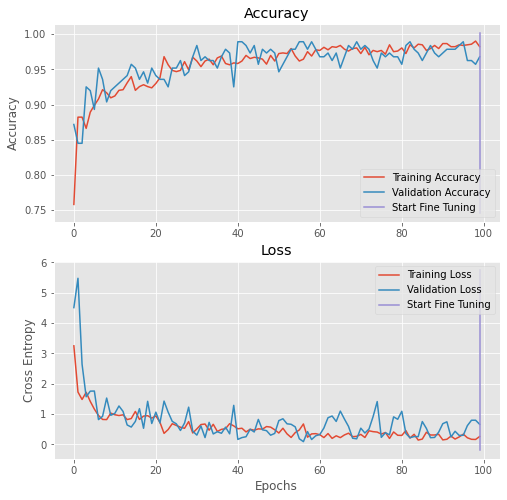

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.6559 - accuracy: 0.9219

2/5 [===========>..................] - ETA: 2s - loss: 3.5062 - accuracy: 0.9336

3/5 [=================>............] - ETA: 2s - loss: 2.4670 - accuracy: 0.9453

4/5 [=======================>......] - ETA: 1s - loss: 1.9458 - accuracy: 0.9570

5/5 [==============================] - ETA: 0s - loss: 1.8120 - accuracy: 0.9576

5/5 [==============================] - 11s 2s/step - loss: 1.8120 - accuracy: 0.9576


[1.8120121955871582, 0.9575971961021423]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

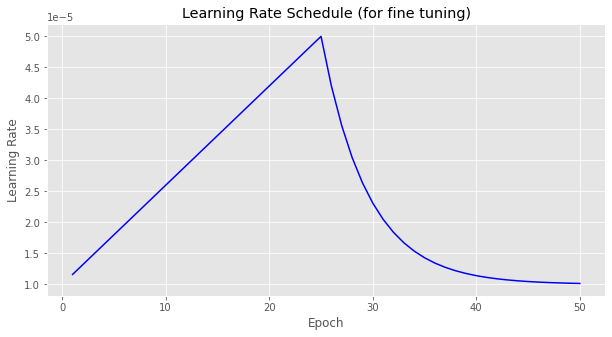

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1128 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/18 [>.............................] - ETA: 0s - loss: 7.8231e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 1.1018e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 9s - loss: 0.0208 - accuracy: 0.9948     

 4/18 [=====>........................] - ETA: 8s - loss: 0.0156 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 15s - loss: 0.1660 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 13s - loss: 0.1604 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 11s - loss: 0.3193 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 10s - loss: 0.2920 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 9s - loss: 0.2742 - accuracy: 0.9828 

11/18 [=================>............] - ETA: 8s - loss: 0.2951 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 6s - loss: 0.3248 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 5s - loss: 0.3081 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.2989 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2790 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2616 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2666 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9840

18/18 [==============================] - 27s 2s/step - loss: 0.2571 - accuracy: 0.9840 - val_loss: 0.4792 - val_accuracy: 0.9679



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.2112 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 12s - loss: 0.1408 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 22s - loss: 0.1982 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1586 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.1589 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1362 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.1193 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1061 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.0955 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.1442 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.1377 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1557 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1446 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1350 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1265 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1384 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1371 - accuracy: 0.9876 - val_loss: 0.3965 - val_accuracy: 0.9733



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1161 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.1353 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 11s - loss: 0.2271 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 9s - loss: 0.1703 - accuracy: 0.9844 

 5/18 [=======>......................] - ETA: 16s - loss: 0.1368 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1390 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.1216 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 11s - loss: 0.1213 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1280 - accuracy: 0.9875

11/18 [=================>............] - ETA: 8s - loss: 0.1166 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.1151 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1062 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 4s - loss: 0.0986 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.1014 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1062 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9876

18/18 [==============================] - 23s 1s/step - loss: 0.1388 - accuracy: 0.9876 - val_loss: 0.3525 - val_accuracy: 0.9733



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/18 [>.............................] - ETA: 0s - loss: 1.1845 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 7s - loss: 0.5922 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 9s - loss: 0.4686 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 11s - loss: 0.3534 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.2830 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 20s - loss: 0.2359 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.2413 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.3255 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 14s - loss: 0.2928 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 12s - loss: 0.2639 - accuracy: 0.9859

11/18 [=================>............] - ETA: 11s - loss: 0.2950 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 9s - loss: 0.2749 - accuracy: 0.9857 

13/18 [====================>.........] - ETA: 7s - loss: 0.2538 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2661 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2966 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.2783 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.2792 - accuracy: 0.9840 - val_loss: 0.3183 - val_accuracy: 0.9786



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 16s - loss: 0.3838 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 15s - loss: 0.3683 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 17s - loss: 0.2762 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 22s - loss: 0.3875 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 19s - loss: 0.5257 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 16s - loss: 0.4801 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 15s - loss: 0.7058 - accuracy: 0.9707

 9/18 [==============>...............] - ETA: 13s - loss: 0.7978 - accuracy: 0.9670

10/18 [===============>..............] - ETA: 11s - loss: 0.7387 - accuracy: 0.9656

11/18 [=================>............] - ETA: 9s - loss: 0.6716 - accuracy: 0.9688 

12/18 [===================>..........] - ETA: 8s - loss: 0.6373 - accuracy: 0.9701

13/18 [====================>.........] - ETA: 7s - loss: 0.5942 - accuracy: 0.9712

14/18 [======================>.......] - ETA: 5s - loss: 0.5520 - accuracy: 0.9732

15/18 [========================>.....] - ETA: 4s - loss: 0.5696 - accuracy: 0.9740

16/18 [=========================>....] - ETA: 2s - loss: 0.5358 - accuracy: 0.9746

17/18 [===========================>..] - ETA: 1s - loss: 0.5209 - accuracy: 0.9752

18/18 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.9761

18/18 [==============================] - 26s 1s/step - loss: 0.5024 - accuracy: 0.9761 - val_loss: 0.3029 - val_accuracy: 0.9786



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/18 [>.............................] - ETA: 0s - loss: 3.3828e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.0749 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 13s - loss: 0.1210 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 14s - loss: 0.1338 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 15s - loss: 0.1070 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.1581 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 16s - loss: 0.1355 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.1372 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 12s - loss: 0.1219 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1097 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2424 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.2282 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2346 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2767 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 4s - loss: 0.2610 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2953 - accuracy: 0.9805

17/18 [===========================>..] - ETA: 1s - loss: 0.2779 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.2772 - accuracy: 0.9814 - val_loss: 0.2823 - val_accuracy: 0.9786



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.2387 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 19s - loss: 0.2244 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 15s - loss: 0.1683 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 17s - loss: 0.3175 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 18s - loss: 0.2647 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.2477 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.2168 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1957 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1821 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.2146 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.2638 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2450 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2290 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2020 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.2119 - accuracy: 0.9840 - val_loss: 0.2861 - val_accuracy: 0.9733



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2329 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 7s - loss: 0.1164 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 13s - loss: 0.1645 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 11s - loss: 0.2107 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 12s - loss: 0.1748 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.1457 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1952 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.1708 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.2439 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2204 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.2499 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9857 

13/18 [====================>.........] - ETA: 7s - loss: 0.2186 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.2231 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2091 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1969 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2282 - accuracy: 0.9867 - val_loss: 0.2821 - val_accuracy: 0.9733



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/18 [>.............................] - ETA: 0s - loss: 3.8370e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 5.8486e-07 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 21s - loss: 0.0578 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 16s - loss: 0.0433 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 20s - loss: 0.0808 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 16s - loss: 0.0749 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 16s - loss: 0.0642 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 14s - loss: 0.0578 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 14s - loss: 0.0617 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 13s - loss: 0.0864 - accuracy: 0.9906

11/18 [=================>............] - ETA: 11s - loss: 0.0786 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 9s - loss: 0.0720 - accuracy: 0.9922 

13/18 [====================>.........] - ETA: 7s - loss: 0.0700 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0683 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.0652 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.0611 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.0576 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9911

18/18 [==============================] - 26s 1s/step - loss: 0.0588 - accuracy: 0.9911 - val_loss: 0.2802 - val_accuracy: 0.9733



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/18 [>.............................] - ETA: 0s - loss: 1.3039e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 7s - loss: 0.2450 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 12s - loss: 0.1843 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 26s - loss: 0.2973 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 24s - loss: 0.2793 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 19s - loss: 0.2401 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 16s - loss: 0.1927 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 14s - loss: 0.2194 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 12s - loss: 0.2063 - accuracy: 0.9828

11/18 [=================>............] - ETA: 10s - loss: 0.2123 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 8s - loss: 0.2084 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.1924 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1844 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1758 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1648 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1687 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9849

18/18 [==============================] - 24s 1s/step - loss: 0.1627 - accuracy: 0.9849 - val_loss: 0.2831 - val_accuracy: 0.9733



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/18 [>.............................] - ETA: 0s - loss: 5.6018e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 7.1518e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 17s - loss: 0.2757 - accuracy: 0.9948   

 4/18 [=====>........................] - ETA: 14s - loss: 0.2333 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.1877 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 17s - loss: 0.2301 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 14s - loss: 0.1972 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.1726 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 12s - loss: 0.1534 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.1619 - accuracy: 0.9906

11/18 [=================>............] - ETA: 10s - loss: 0.2010 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 8s - loss: 0.1917 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 6s - loss: 0.2159 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.2006 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.1872 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.2047 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2054 - accuracy: 0.9867 - val_loss: 0.2890 - val_accuracy: 0.9733



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5764 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 6s - loss: 0.3213 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 19s - loss: 0.6354 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 15s - loss: 0.5721 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 18s - loss: 0.4577 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 15s - loss: 0.4200 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 16s - loss: 0.3778 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 13s - loss: 0.3935 - accuracy: 0.9746

 9/18 [==============>...............] - ETA: 12s - loss: 0.3500 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 10s - loss: 0.3150 - accuracy: 0.9797

11/18 [=================>............] - ETA: 9s - loss: 0.2995 - accuracy: 0.9801 

12/18 [===================>..........] - ETA: 8s - loss: 0.2745 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 7s - loss: 0.3057 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.3177 - accuracy: 0.9788

15/18 [========================>.....] - ETA: 4s - loss: 0.3075 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.2952 - accuracy: 0.9785

17/18 [===========================>..] - ETA: 1s - loss: 0.2949 - accuracy: 0.9789

18/18 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9796

18/18 [==============================] - 25s 1s/step - loss: 0.2844 - accuracy: 0.9796 - val_loss: 0.2925 - val_accuracy: 0.9733



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5687 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 23s - loss: 0.3465 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 20s - loss: 0.4537 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 25s - loss: 0.3403 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 20s - loss: 0.2723 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 17s - loss: 0.2405 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.2385 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 15s - loss: 0.2087 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2113 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2222 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.3026 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 8s - loss: 0.2774 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.2603 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2417 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.2465 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2391 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.2177 - accuracy: 0.9867 - val_loss: 0.3025 - val_accuracy: 0.9733



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0376 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.0193 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 17s - loss: 0.0129 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 13s - loss: 0.0097 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 19s - loss: 0.1424 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1187 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 14s - loss: 0.1017 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.1329 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 14s - loss: 0.1590 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 13s - loss: 0.1431 - accuracy: 0.9875

11/18 [=================>............] - ETA: 11s - loss: 0.1357 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.1244 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1148 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1066 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.1237 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1307 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1231 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1370 - accuracy: 0.9894 - val_loss: 0.3010 - val_accuracy: 0.9733



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4163 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 19s - loss: 0.2285 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.1523 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.2053 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 19s - loss: 0.1642 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1982 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.5327 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 15s - loss: 0.4661 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.4586 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.5270 - accuracy: 0.9797

11/18 [=================>............] - ETA: 9s - loss: 0.4913 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 8s - loss: 0.4504 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 7s - loss: 0.4266 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.3962 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 4s - loss: 0.3958 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.3836 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.9823

18/18 [==============================] - 25s 1s/step - loss: 0.3596 - accuracy: 0.9823 - val_loss: 0.3063 - val_accuracy: 0.9733



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2242 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 16s - loss: 0.1121 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 15s - loss: 0.0747 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.1024 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 16s - loss: 0.1341 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 13s - loss: 0.1117 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.1195 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.1045 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.0991 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1159 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1506 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1400 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1302 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.1215 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1228 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1241 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.1288 - accuracy: 0.9858 - val_loss: 0.3118 - val_accuracy: 0.9733



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1296 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 18s - loss: 0.0648 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 17s - loss: 0.1437 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.1078 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 19s - loss: 0.0914 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 17s - loss: 0.1126 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1123 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.0998 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.0985 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.0896 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.0846 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.0782 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 6s - loss: 0.0830 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.0995 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1207 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1215 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9858

18/18 [==============================] - 26s 1s/step - loss: 0.1172 - accuracy: 0.9858 - val_loss: 0.3174 - val_accuracy: 0.9733



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/18 [>.............................] - ETA: 0s - loss: 1.6539e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 12s - loss: 8.2695e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 23s - loss: 5.5130e-06 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 19s - loss: 0.0099 - accuracy: 0.9961    

 5/18 [=======>......................] - ETA: 20s - loss: 0.0079 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 16s - loss: 0.1093 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.2076 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1857 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 12s - loss: 0.1672 - accuracy: 0.9891

11/18 [=================>............] - ETA: 11s - loss: 0.1520 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 9s - loss: 0.1393 - accuracy: 0.9909 

13/18 [====================>.........] - ETA: 7s - loss: 0.1310 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1217 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.1150 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1126 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1080 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9902

18/18 [==============================] - 25s 1s/step - loss: 0.1042 - accuracy: 0.9902 - val_loss: 0.3158 - val_accuracy: 0.9733



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/18 [>.............................] - ETA: 0s - loss: 1.0375e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.3103 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 18s - loss: 0.3216 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.2883 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.2306 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1970 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1971 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.2333 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.2073 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2403 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2203 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2413 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2300 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.2338 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2802 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2743 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.2645 - accuracy: 0.9832 - val_loss: 0.3084 - val_accuracy: 0.9733



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 0.1139 - accuracy: 0.9844   

 3/18 [====>.........................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.4160 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 20s - loss: 0.5662 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 16s - loss: 0.4718 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 17s - loss: 0.4214 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.4306 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.4231 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.3808 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.3882 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 8s - loss: 0.3616 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 6s - loss: 0.3891 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.4550 - accuracy: 0.9777

15/18 [========================>.....] - ETA: 4s - loss: 0.4393 - accuracy: 0.9771

16/18 [=========================>....] - ETA: 2s - loss: 0.4224 - accuracy: 0.9775

17/18 [===========================>..] - ETA: 1s - loss: 0.3976 - accuracy: 0.9789

18/18 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.9787

18/18 [==============================] - 25s 1s/step - loss: 0.3990 - accuracy: 0.9787 - val_loss: 0.2985 - val_accuracy: 0.9733



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/18 [>.............................] - ETA: 0s - loss: 0.7663 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 11s - loss: 0.4556 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 22s - loss: 0.3064 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 17s - loss: 0.2298 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 16s - loss: 0.3761 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.5977 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 16s - loss: 0.5124 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.5523 - accuracy: 0.9746

 9/18 [==============>...............] - ETA: 13s - loss: 0.4909 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 11s - loss: 0.4418 - accuracy: 0.9797

11/18 [=================>............] - ETA: 9s - loss: 0.4018 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 8s - loss: 0.3692 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.4376 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.4066 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 4s - loss: 0.3934 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3688 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3565 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.3439 - accuracy: 0.9832 - val_loss: 0.3042 - val_accuracy: 0.9733



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2024 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.1012 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 13s - loss: 0.1025 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 12s - loss: 0.0787 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.0630 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 14s - loss: 0.0797 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 15s - loss: 0.0684 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 14s - loss: 0.0599 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 12s - loss: 0.0726 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.0797 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0725 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.1158 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1070 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1773 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1655 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1552 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1461 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9911

18/18 [==============================] - 24s 1s/step - loss: 0.1409 - accuracy: 0.9911 - val_loss: 0.3198 - val_accuracy: 0.9733



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 0.0603 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 18s - loss: 0.0817 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.1478 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.1629 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.2578 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.2684 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 15s - loss: 0.2434 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.1947 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1993 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 8s - loss: 0.2780 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.2593 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.2458 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.2466 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2436 - accuracy: 0.9805

17/18 [===========================>..] - ETA: 1s - loss: 0.2473 - accuracy: 0.9807

18/18 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.2385 - accuracy: 0.9814 - val_loss: 0.3255 - val_accuracy: 0.9733



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/18 [>.............................] - ETA: 0s - loss: 1.2480e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 23s - loss: 6.2398e-08 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 17s - loss: 0.0751 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 16s - loss: 0.0564 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 19s - loss: 0.0565 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 17s - loss: 0.2113 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1811 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 15s - loss: 0.1585 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1416 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1941 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1890 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1732 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1607 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.2634 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2551 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2391 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.2352 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9823

18/18 [==============================] - 24s 1s/step - loss: 0.2567 - accuracy: 0.9823 - val_loss: 0.3416 - val_accuracy: 0.9733



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 17s - loss: 0.0210 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 17s - loss: 0.1097 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 13s - loss: 0.0865 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 19s - loss: 0.0740 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.0875 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.0778 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 10s - loss: 0.0700 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0826 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 7s - loss: 0.1163 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1418 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1558 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1454 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1509 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1446 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1395 - accuracy: 0.9885 - val_loss: 0.3362 - val_accuracy: 0.9733



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/18 [>.............................] - ETA: 0s - loss: 1.3703e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 0.1569 - accuracy: 0.9766    

 3/18 [====>.........................] - ETA: 8s - loss: 0.1046 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.0785 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.0628 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 14s - loss: 0.0523 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 13s - loss: 0.0490 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 11s - loss: 0.0429 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 11s - loss: 0.0465 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 10s - loss: 0.0904 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.0822 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 7s - loss: 0.1066 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1462 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1368 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1277 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1198 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1127 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9902

18/18 [==============================] - 23s 1s/step - loss: 0.1087 - accuracy: 0.9902 - val_loss: 0.3381 - val_accuracy: 0.9733



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 7s - loss: 0.1486 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 11s - loss: 0.2483 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 13s - loss: 0.1862 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.1527 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1382 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1825 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.1690 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1988 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 12s - loss: 0.2104 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2096 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 8s - loss: 0.1925 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 6s - loss: 0.1776 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1650 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1540 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1923 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1810 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1925 - accuracy: 0.9876 - val_loss: 0.3305 - val_accuracy: 0.9733



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0529 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 8s - loss: 0.2778 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 15s - loss: 0.1852 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 12s - loss: 0.1389 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.1517 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 18s - loss: 0.1265 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1084 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 13s - loss: 0.0949 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 11s - loss: 0.0843 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 10s - loss: 0.0759 - accuracy: 0.9937

11/18 [=================>............] - ETA: 8s - loss: 0.0690 - accuracy: 0.9943 

12/18 [===================>..........] - ETA: 7s - loss: 0.1331 - accuracy: 0.9922

13/18 [====================>.........] - ETA: 6s - loss: 0.1453 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 4s - loss: 0.2128 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1990 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1871 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1761 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9911

18/18 [==============================] - 23s 1s/step - loss: 0.1699 - accuracy: 0.9911 - val_loss: 0.3297 - val_accuracy: 0.9733



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/18 [>.............................] - ETA: 0s - loss: 2.0209e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 13s - loss: 0.0144 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 17s - loss: 0.0096 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 19s - loss: 0.0078 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.0302 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.0891 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.1131 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 15s - loss: 0.1019 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 14s - loss: 0.1478 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 12s - loss: 0.1410 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1780 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.2655 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.3115 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.2895 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 4s - loss: 0.2710 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2541 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2391 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2306 - accuracy: 0.9858 - val_loss: 0.3275 - val_accuracy: 0.9733



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/18 [>.............................] - ETA: 0s - loss: 0.7439 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 16s - loss: 0.3724 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 24s - loss: 0.3177 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 19s - loss: 0.3317 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 21s - loss: 0.3902 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 18s - loss: 0.3251 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.3135 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.2745 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 14s - loss: 0.3432 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 13s - loss: 0.3103 - accuracy: 0.9828

11/18 [=================>............] - ETA: 11s - loss: 0.3022 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 9s - loss: 0.3026 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.2793 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2593 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.2421 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2269 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2113 - accuracy: 0.9858 - val_loss: 0.3362 - val_accuracy: 0.9733



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1558 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 17s - loss: 0.0519 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1582 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.2816 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 17s - loss: 0.2424 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.2121 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1904 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.2283 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2184 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2002 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1875 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1741 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1625 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1601 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1506 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9885

18/18 [==============================] - 25s 1s/step - loss: 0.1493 - accuracy: 0.9885 - val_loss: 0.3422 - val_accuracy: 0.9733



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/18 [>.............................] - ETA: 0s - loss: 9.6753e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 4.8414e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 19s - loss: 0.0073 - accuracy: 0.9948   

 4/18 [=====>........................] - ETA: 15s - loss: 0.0055 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 15s - loss: 0.0078 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 14s - loss: 0.0736 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 15s - loss: 0.0631 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 13s - loss: 0.0835 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1374 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1433 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1303 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1225 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1131 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1608 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1530 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1434 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1350 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1302 - accuracy: 0.9885 - val_loss: 0.3403 - val_accuracy: 0.9733



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/18 [>.............................] - ETA: 0s - loss: 2.3477e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 7s - loss: 0.2129 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 14s - loss: 0.6392 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 13s - loss: 0.4794 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 18s - loss: 0.4536 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 14s - loss: 0.3781 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 17s - loss: 0.3241 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.3774 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.3355 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.3058 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.2784 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.2570 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.2372 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.2203 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.2172 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.2419 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2277 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.2343 - accuracy: 0.9849 - val_loss: 0.3431 - val_accuracy: 0.9733



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/18 [>.............................] - ETA: 0s - loss: 4.0893e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 1.6551e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 15s - loss: 0.0415 - accuracy: 0.9896   

 4/18 [=====>........................] - ETA: 15s - loss: 0.0848 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 14s - loss: 0.1052 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 13s - loss: 0.0877 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1421 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 12s - loss: 0.1244 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1648 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.1483 - accuracy: 0.9875

11/18 [=================>............] - ETA: 8s - loss: 0.1560 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.1531 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1885 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 4s - loss: 0.1762 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1683 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1578 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.1485 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9849

18/18 [==============================] - 23s 1s/step - loss: 0.1581 - accuracy: 0.9849 - val_loss: 0.3296 - val_accuracy: 0.9733



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0476 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.2328 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 16s - loss: 0.1556 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.1450 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 18s - loss: 0.2432 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.3535 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 13s - loss: 0.3523 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.3131 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.2840 - accuracy: 0.9812

11/18 [=================>............] - ETA: 10s - loss: 0.3581 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 8s - loss: 0.3283 - accuracy: 0.9818 

13/18 [====================>.........] - ETA: 6s - loss: 0.3634 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.3384 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.3257 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3251 - accuracy: 0.9814

17/18 [===========================>..] - ETA: 1s - loss: 0.3113 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.9823

18/18 [==============================] - 25s 1s/step - loss: 0.3002 - accuracy: 0.9823 - val_loss: 0.3243 - val_accuracy: 0.9733



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/18 [>.............................] - ETA: 0s - loss: 3.0768e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 15s - loss: 0.0363 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 23s - loss: 0.1583 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.1188 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.2414 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.2610 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 13s - loss: 0.2283 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.2030 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.1827 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.1661 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.1619 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 7s - loss: 0.2184 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.2206 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 4s - loss: 0.2129 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2772 - accuracy: 0.9814

17/18 [===========================>..] - ETA: 1s - loss: 0.2609 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.2517 - accuracy: 0.9832 - val_loss: 0.3285 - val_accuracy: 0.9733



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 24s - loss: 0.0339 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 17s - loss: 0.0226 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.0214 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 20s - loss: 0.0337 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.0562 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.0769 - accuracy: 0.9906

11/18 [=================>............] - ETA: 10s - loss: 0.0999 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 8s - loss: 0.1031 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 6s - loss: 0.1430 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1463 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.1365 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1436 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1447 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.1573 - accuracy: 0.9867 - val_loss: 0.3328 - val_accuracy: 0.9733



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/18 [>.............................] - ETA: 0s - loss: 1.3039e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.5155 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 18s - loss: 0.3452 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 16s - loss: 0.2589 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.4066 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.3786 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.3245 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.2967 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.2637 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.2430 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.2211 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.2029 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 6s - loss: 0.1873 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.1740 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 3s - loss: 0.1624 - accuracy: 0.9948

16/18 [=========================>....] - ETA: 2s - loss: 0.1522 - accuracy: 0.9951

17/18 [===========================>..] - ETA: 1s - loss: 0.1582 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9938

18/18 [==============================] - 24s 1s/step - loss: 0.1526 - accuracy: 0.9938 - val_loss: 0.3331 - val_accuracy: 0.9733



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/18 [>.............................] - ETA: 0s - loss: 7.7355e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 20s - loss: 0.2338 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 21s - loss: 0.1560 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 25s - loss: 0.1170 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 20s - loss: 0.0936 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 18s - loss: 0.1090 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 15s - loss: 0.0934 - accuracy: 0.9955

 8/18 [============>.................] - ETA: 15s - loss: 0.1652 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.1469 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9937

11/18 [=================>............] - ETA: 10s - loss: 0.1291 - accuracy: 0.9929

12/18 [===================>..........] - ETA: 8s - loss: 0.1548 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 6s - loss: 0.1430 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1332 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.1419 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1371 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1816 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.1752 - accuracy: 0.9867 - val_loss: 0.3274 - val_accuracy: 0.9733



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3019 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 15s - loss: 0.1510 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 23s - loss: 0.1299 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 18s - loss: 0.1574 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.1745 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.1455 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 15s - loss: 0.1201 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1070 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 13s - loss: 0.0963 - accuracy: 0.9922

11/18 [=================>............] - ETA: 11s - loss: 0.0899 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 9s - loss: 0.1407 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 7s - loss: 0.1299 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1207 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.1503 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1863 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1754 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9885

18/18 [==============================] - 26s 1s/step - loss: 0.1695 - accuracy: 0.9885 - val_loss: 0.3356 - val_accuracy: 0.9733



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/18 [>.............................] - ETA: 0s - loss: 1.2293e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 0.4049 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 18s - loss: 0.5620 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 14s - loss: 0.4218 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 14s - loss: 0.3593 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 13s - loss: 0.3003 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 13s - loss: 0.3320 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.2905 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.2583 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.2324 - accuracy: 0.9922

11/18 [=================>............] - ETA: 10s - loss: 0.2117 - accuracy: 0.9929

12/18 [===================>..........] - ETA: 8s - loss: 0.1940 - accuracy: 0.9935 

13/18 [====================>.........] - ETA: 6s - loss: 0.2044 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.2029 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 3s - loss: 0.2014 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1888 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1948 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9911

18/18 [==============================] - 24s 1s/step - loss: 0.1879 - accuracy: 0.9911 - val_loss: 0.3462 - val_accuracy: 0.9733



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 7s - loss: 0.1251 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 7s - loss: 0.1762 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 14s - loss: 0.1322 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 13s - loss: 0.1339 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 13s - loss: 0.1116 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 13s - loss: 0.0957 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 12s - loss: 0.0837 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 11s - loss: 0.0794 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 10s - loss: 0.0789 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.0717 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.0708 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 7s - loss: 0.0654 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.0607 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.0566 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.1155 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1234 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9894

18/18 [==============================] - 24s 1s/step - loss: 0.1207 - accuracy: 0.9894 - val_loss: 0.3577 - val_accuracy: 0.9733



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4153 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 9s - loss: 0.2077 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 16s - loss: 0.2860 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.3357 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 14s - loss: 0.2689 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 14s - loss: 0.2241 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.2353 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.2059 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.2159 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1963 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.1818 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1678 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.2039 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1903 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.2061 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.2004 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1933 - accuracy: 0.9885 - val_loss: 0.3559 - val_accuracy: 0.9733



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5176 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 8s - loss: 0.5528 - accuracy: 0.9609

 3/18 [====>.........................] - ETA: 12s - loss: 0.5738 - accuracy: 0.9635

 4/18 [=====>........................] - ETA: 13s - loss: 0.4303 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 17s - loss: 0.4119 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 14s - loss: 0.3884 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 15s - loss: 0.3329 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 12s - loss: 0.3754 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 12s - loss: 0.3745 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 11s - loss: 0.3387 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.3079 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 7s - loss: 0.2933 - accuracy: 0.9779

13/18 [====================>.........] - ETA: 6s - loss: 0.2835 - accuracy: 0.9784

14/18 [======================>.......] - ETA: 5s - loss: 0.2880 - accuracy: 0.9788

15/18 [========================>.....] - ETA: 3s - loss: 0.2823 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.2726 - accuracy: 0.9785

17/18 [===========================>..] - ETA: 1s - loss: 0.2566 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9805

18/18 [==============================] - 24s 1s/step - loss: 0.2475 - accuracy: 0.9805 - val_loss: 0.3700 - val_accuracy: 0.9733



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0781 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 19s - loss: 0.0617 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.1529 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.1940 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 22s - loss: 0.3435 - accuracy: 0.9688

 6/18 [=========>....................] - ETA: 20s - loss: 0.3112 - accuracy: 0.9688

 7/18 [==========>...................] - ETA: 16s - loss: 0.3318 - accuracy: 0.9688

 8/18 [============>.................] - ETA: 15s - loss: 0.2930 - accuracy: 0.9707

 9/18 [==============>...............] - ETA: 13s - loss: 0.2604 - accuracy: 0.9740

10/18 [===============>..............] - ETA: 11s - loss: 0.2344 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.2131 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 8s - loss: 0.2020 - accuracy: 0.9792

13/18 [====================>.........] - ETA: 6s - loss: 0.1865 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.1732 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.1616 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2113 - accuracy: 0.9805

17/18 [===========================>..] - ETA: 1s - loss: 0.2109 - accuracy: 0.9807

18/18 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9805

18/18 [==============================] - 24s 1s/step - loss: 0.2151 - accuracy: 0.9805 - val_loss: 0.3656 - val_accuracy: 0.9733



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 14s - loss: 0.1429 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 23s - loss: 0.0953 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 18s - loss: 0.1059 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.0847 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.0706 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.0971 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 15s - loss: 0.1367 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1216 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.1130 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1913 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2045 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1888 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1872 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1747 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1681 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1835 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.1789 - accuracy: 0.9867 - val_loss: 0.3697 - val_accuracy: 0.9733



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/18 [>.............................] - ETA: 0s - loss: 1.1259e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.1497 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 19s - loss: 0.1199 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.0943 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.0963 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.2052 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.2332 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2810 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 12s - loss: 0.2989 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.2690 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.2467 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 8s - loss: 0.2380 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.2197 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.2040 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1904 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1785 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1681 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.1682 - accuracy: 0.9867 - val_loss: 0.3661 - val_accuracy: 0.9733



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/18 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.0385 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 15s - loss: 0.0256 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 13s - loss: 0.0192 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.0320 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.0816 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 15s - loss: 0.0730 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 13s - loss: 0.0639 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 12s - loss: 0.0568 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.1037 - accuracy: 0.9906

11/18 [=================>............] - ETA: 9s - loss: 0.0943 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 8s - loss: 0.0864 - accuracy: 0.9922

13/18 [====================>.........] - ETA: 6s - loss: 0.0798 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.0741 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 3s - loss: 0.0800 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0750 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.0752 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9911

18/18 [==============================] - 24s 1s/step - loss: 0.0761 - accuracy: 0.9911 - val_loss: 0.3550 - val_accuracy: 0.9733



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0602 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 11s - loss: 0.2810 - accuracy: 0.9609

 3/18 [====>.........................] - ETA: 27s - loss: 0.2399 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 21s - loss: 0.2827 - accuracy: 0.9688

 5/18 [=======>......................] - ETA: 17s - loss: 0.2263 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 15s - loss: 0.1886 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.2163 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 15s - loss: 0.1893 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.1705 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.1541 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.1401 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.1705 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.1619 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.1593 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 4s - loss: 0.1488 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1467 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.1331 - accuracy: 0.9840 - val_loss: 0.3519 - val_accuracy: 0.9733



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/18 [>.............................] - ETA: 0s - loss: 0.6615 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 25s - loss: 0.4669 - accuracy: 0.9609

 3/18 [====>.........................] - ETA: 18s - loss: 0.3253 - accuracy: 0.9635

 4/18 [=====>........................] - ETA: 14s - loss: 0.2848 - accuracy: 0.9688

 5/18 [=======>......................] - ETA: 16s - loss: 0.2278 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 13s - loss: 0.1899 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.1627 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.1424 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.1266 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1194 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1284 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.1177 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1096 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1053 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.1211 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1199 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.1471 - accuracy: 0.9858 - val_loss: 0.3553 - val_accuracy: 0.9733


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

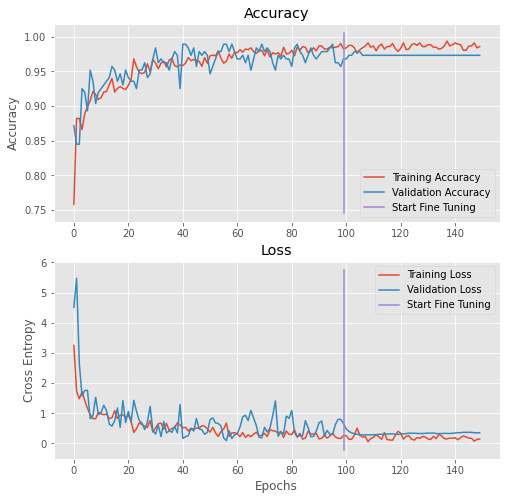

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.3467 - accuracy: 0.9609

2/5 [===========>..................] - ETA: 2s - loss: 2.0748 - accuracy: 0.9570

3/5 [=================>............] - ETA: 2s - loss: 1.5197 - accuracy: 0.9609

4/5 [=======================>......] - ETA: 1s - loss: 1.2463 - accuracy: 0.9668

5/5 [==============================] - ETA: 0s - loss: 1.1571 - accuracy: 0.9647

5/5 [==============================] - 6s 1s/step - loss: 1.1571 - accuracy: 0.9647


[1.1571301221847534, 0.9646643400192261]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9646643109540636
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       164
           1       0.98      0.97      0.97       402

    accuracy                           0.96       566
   macro avg       0.95      0.96      0.96       566
weighted avg       0.97      0.96      0.96       566



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

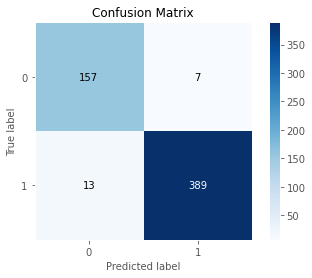

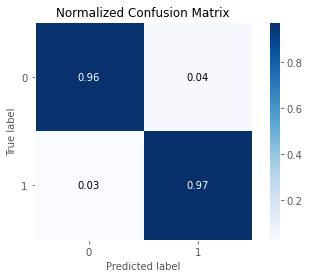

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

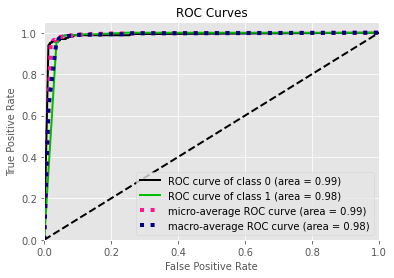

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       164
           1       0.98      0.97      0.97       402

    accuracy                           0.96       566
   macro avg       0.95      0.96      0.96       566
weighted avg       0.97      0.96      0.96       566

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.96      0.97      0.94      0.96      0.93       164
          1       0.98      0.97      0.96      0.97      0.96      0.93       402

avg / total       0.97      0.96      0.96      0.96      0.96      0.93       566

